In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style
import h5py    

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import datetime

import scqubits as scq
import qutip as qt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from scipy.optimize import minimize

#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen


import scipy.constants as cst

from PulseSequence import PulseSequence
from QSwitch import QSwitch

import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

%matplotlib widget
%config InlineBackend.figure_format = 'svg'

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True


two_qb = True

ModuleNotFoundError: No module named 'PulseSequence'

# Define the optimal gate

In [342]:
# define the ideal gate

if two_qb:
    cutoffs = [2, 2]
else:
    cutoffs = [2, 2, 2, 2]



U_q0 = qt.qeye(cutoffs[0])
U_q1_mat = np.eye(cutoffs[1], dtype=complex)
U_q1_mat[:2, :2] = np.array([[0, 1], [1, 0]])
U_q1 = qt.Qobj(U_q1_mat, dims=[[cutoffs[1]], [cutoffs[1]]])


if two_qb:
    U_goal = qt.tensor(U_q0, U_q1)
else:
    U_q2 = qt.qeye(cutoffs[2])
    U_q3 = qt.qeye(cutoffs[3])
    U_goal = qt.tensor(U_q0, U_q1, U_q2, U_q3)
# U_goal = qt.tensor(U_q0, U_q1)



# Set qubit parameters

In [343]:
EJs = None
ECs = None
rotating_frame = False

if two_qb:
    qubit_freqs = np.array([4140.533743739655, 3463.7283737734433])*1e-3
    ef_freqs = np.array([3914.7570214638718, 3363.398427976613])*1e-3
    alphas = ef_freqs - qubit_freqs
    ZZ = np.array([[ 0.,-5.10982939],[-5.10982939,0.]])*1e-3
else:
    qubit_freqs = np.array([4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773])*1e-3
    ef_freqs = np.array([3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869358])*1e-3
    alphas = ef_freqs - qubit_freqs
    # gs = np.array([54.38663964, 52.60236201, 41.1249601,   6.26475719,  2.73059709,  6.00700312])*1e-3 # g01, g12, g13
    ZZ = np.array([[ 0.,-5.10982939,-0.18457118,-0.50235316],[-5.10982939,0.,-0.94914758,-1.07618574], 
                [-0.18457118,-0.94914758 ,0.,-0.44607489], [-0.50235316, -1.07618574, -0.44607489 , 0.]])*1e-3


In [344]:
# cutoffs = [2, 2, 2, 2]
# isCavity = [False, False, False, False]
isCavity = [False, False, False, False]



qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=None,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    is2Q=two_qb,
    useZZs=True, ZZs=ZZ
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)
# print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 4.140533743739655 3.4637283737734434
alphas (GHz) -0.22577672227578338 -0.10032994579683008
aprox sideband freqs (GHz) [2.68659306 3.36339843]


In [345]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -5.10982939]
 [-5.10982939  0.        ]]


 # Define the Hamiltonian 

In [346]:
index_to_drive = [1]


H_drift = qram.H_rot()
H_control_I = [(qram.a_ops[i] + qram.a_ops[i].dag())/2*2*np.pi for i in index_to_drive]
H_control_Q = [(qram.a_ops[i] - qram.a_ops[i].dag())/2*2*np.pi*1j for i in index_to_drive]

H_control = H_control_I +  H_control_Q

n_ctrls = len(H_control)
if two_qb:
    U_0 = qt.tensor(qt.qeye(cutoffs[0]), qt.qeye(cutoffs[1]))
else:
    U_0 = qt.tensor(qt.qeye(cutoffs[0]), qt.qeye(cutoffs[1]), qt.qeye(cutoffs[2]), qt.qeye(cutoffs[3]))
# U_0 = qt.tensor(qt.qeye(cutoffs[0]), qt.qeye(cutoffs[1]))

# Define the time evolution parameters 

In [347]:
# Number of time slots
n_ts = 200
# Time allowed for the evolution
evo_time = 40

In [348]:
# Fidelity error target
fid_err_targ = 1e-2
# Maximum iterations for the optisation algorithm
max_iter = 10000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300

amp_max = 0.01*2*np.pi

In [349]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}.txt".format("qram", n_ts)

In [370]:
optim = cpo.create_pulse_optimizer(H_drift, H_control, U_0, U_goal, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                alg='CRAB', 
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'SU'}, 
                log_level=log_level, gen_stats=True)

In [371]:
dyn = optim.dynamics


# # Control 1
# crab_pgen = optim.pulse_generator[0]
# # Start from a ramped pulse
# guess_pgen = pulsegen.create_pulse_gen('ZERO', dyn=dyn)
# crab_pgen.guess_pulse = guess_pgen.gen_pulse()
# crab_pgen.scaling = 1.0
# crab_pgen.lbound = -0.1
# crab_pgen.ubound = 0.1



# Control 2
crab_pgen = optim.pulse_generator[0]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('RND', dyn=dyn)
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()

# # Control 3
# crab_pgen = optim.pulse_generator[2]
# # Add bounds
# crab_pgen.scaling = 0.5
crab_pgen.lbound = -amp_max
crab_pgen.ubound = amp_max

crab_pgen = optim.pulse_generator[1]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('RND', dyn=dyn)
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()

# # Control 3
# crab_pgen = optim.pulse_generator[2]
# # Add bounds
# crab_pgen.scaling = 0.5
crab_pgen.lbound = -amp_max
crab_pgen.ubound = amp_max


# # Control 4
# crab_pgen = optim.pulse_generator[3]
# # Start from a triangular pulse with small signal
# guess_pgen = pulsegen.PulseGenTriangle(dyn=dyn)
# guess_pgen.num_waves = 1
# guess_pgen.scaling = 2.0
# guess_pgen.offset = 2.0
# crab_pgen.guess_pulse = guess_pgen.gen_pulse()
crab_pgen.scaling = 0.1

init_amps = np.zeros([n_ts, n_ctrls])
for j in range(dyn.num_ctrls):
    pgen = optim.pulse_generator[j]
    pgen.init_pulse()
    init_amps[:, j] = pgen.gen_pulse()

dyn.initialize_controls(init_amps)

INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 3, which means a total of 6 optimisation variables for this pulse. Based on the dimension (4) of the system
INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 3, which means a total of 6 optimisation variables for this pulse. Based on the dimension (4) of the system
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False


In [372]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

INFO:qutip.control.optimizer:Optimising pulse(s) using CRAB with 'fmin' (Nelder-Mead) method


Initial amplitudes output to file: ctrl_amps_initial_qram_n_ts200.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_qram_n_ts200.txt


In [373]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:01:32.388394
Wall time computing Hamiltonians: 0:00:06.480868 (7.01%)
Wall time computing propagators: 0:01:22.534313 (89.33%)
Wall time computing forward propagation: 0:00:01.179533 (1.28%)
Wall time computing onward propagation: 0:00:01.167865 (1.26%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 5181
Number of fidelity function calls: 7107
Number of times fidelity is computed: 7108
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 7108

**** Control amplitudes ****
Number of control amplitude updates: 7107
Mean number of updates per iteration: 1.371742906774754
Number of timeslot values changed: 919067
Mean number of timeslot changes per update: 129.31855916701844
Number of amplitude values c

__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412

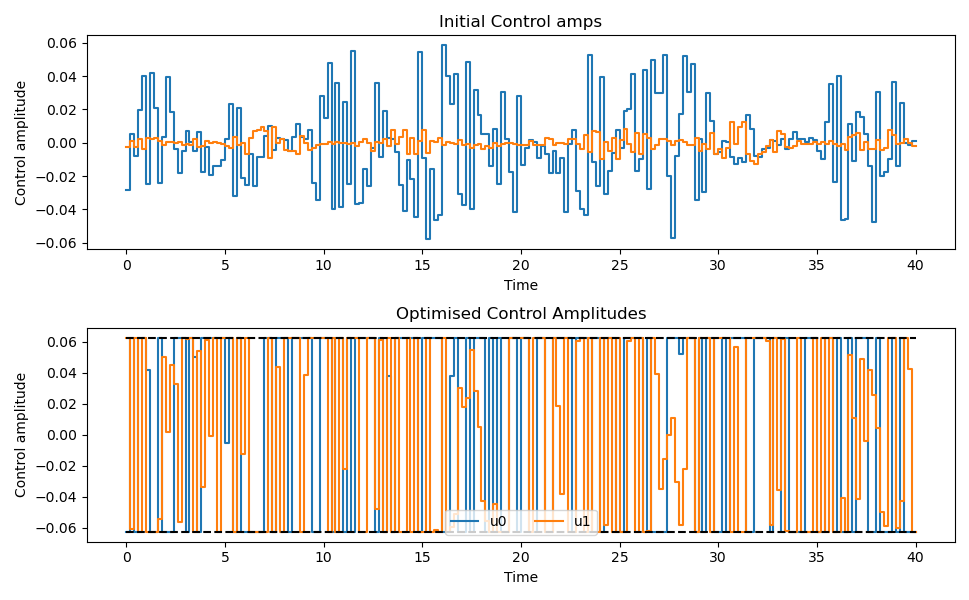

In [379]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post', label='u{}'.format(j))
ax2.legend(loc=8, ncol=n_ctrls)
plt.tight_layout()

# add the pulses bounds

ax2.hlines(optim.pulse_generator[0].lbound, 0, evo_time, color='k', linestyle='--')
ax2.hlines(optim.pulse_generator[0].ubound, 0, evo_time, color='k', linestyle='--')

In [380]:
H0 = H_drift
U_vec = []

if two_qb:
    U = qt.tensor(qt.qeye(cutoffs[0]), qt.qeye(cutoffs[1]))
else:
    U = qt.tensor(qt.qeye(cutoffs[0]), qt.qeye(cutoffs[1]), qt.qeye(cutoffs[2]), qt.qeye(cutoffs[3]))

t_comp= np.linspace(0, evo_time, n_ts)

for t in tqdm(range(len(t_comp))):
    H_t = H0
    for k in range(len(H_control)):
        coeff = result.final_amps[t,k]
        ht = float(coeff)*H_control[k]
        H_t += ht
    argmt = -1j*H_t*t_comp[1]
    U_t = argmt.expm()
    U  = U_t*U
    U_vec.append(U)

100%|██████████| 200/200 [00:00<00:00, 1507.03it/s]


__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412

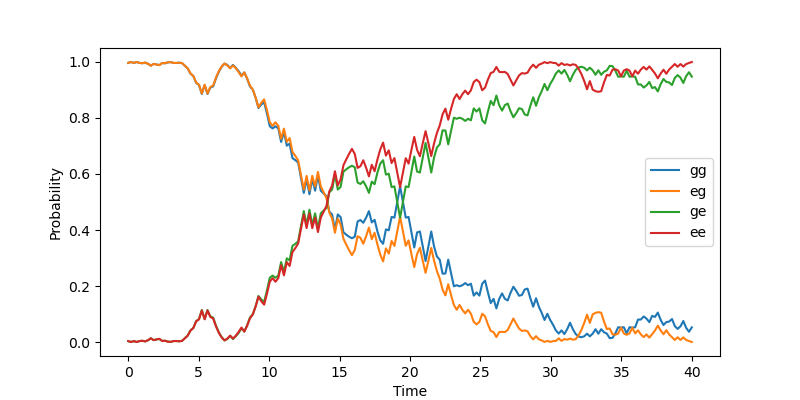

In [381]:
# plot the state evolution

if two_qb:
    gg = qram.state('gg')
    eg = qram.state('eg')
    ge = qram.state('ge')
    ee = qram.state('ee')
else:

    gg = qram.state('gggg')
    eg = qram.state('eggg')
    ge = qram.state('gegg')
    ee = qram.state('eegg')

prob_gg = [np.abs(gg.dag().overlap(U_vec[t]*gg))**2 for t in range(len(U_vec))]
prob_eg = [np.abs(eg.dag().overlap(U_vec[t]*eg))**2 for t in range(len(U_vec))]
prob_ge = [np.abs(ge.dag().overlap(U_vec[t]*gg))**2 for t in range(len(U_vec))]
prob_ee = [np.abs(ee.dag().overlap(U_vec[t]*eg))**2 for t in range(len(U_vec))]


fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(t_comp,prob_gg , label='gg')
ax.plot(t_comp,prob_eg , label='eg')
ax.plot(t_comp,prob_ge , label='ge')
ax.plot(t_comp,prob_ee , label='ee')

ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend(loc=0)


In [382]:
# psi_test = (qram.state('ggee') + qram.state('egee')).unit()
# psi_test = (qram.state('gggg') + qram.state('eggg')).unit()
if two_qb:
    psi_test = (qram.state('gg') + qram.state('eg')).unit()
else:
    psi_test = (qram.state('gggg') + qram.state('eggg')).unit()

psi_fin = U_vec[-1]*psi_test

In [383]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_id, title=None, cmax=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.suptitle(title)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_id), ax=ax1, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax2, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)


In [386]:
tomo_qubits = [0, 1]
result2q = qt.ptrace(psi_fin.unit(), tomo_qubits)
orig_dims = result2q.dims[0]
print('orig dims', orig_dims)

states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
print('extract state indices', states_inds)
rho_result2q = result2q.extract_states(states_inds, normalize=True)


id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_result2q  = qt.Qobj(rho_result2q , dims=id2q.dims, shape=id2q.shape).unit()

__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
 /Users/sebastien/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py: 412

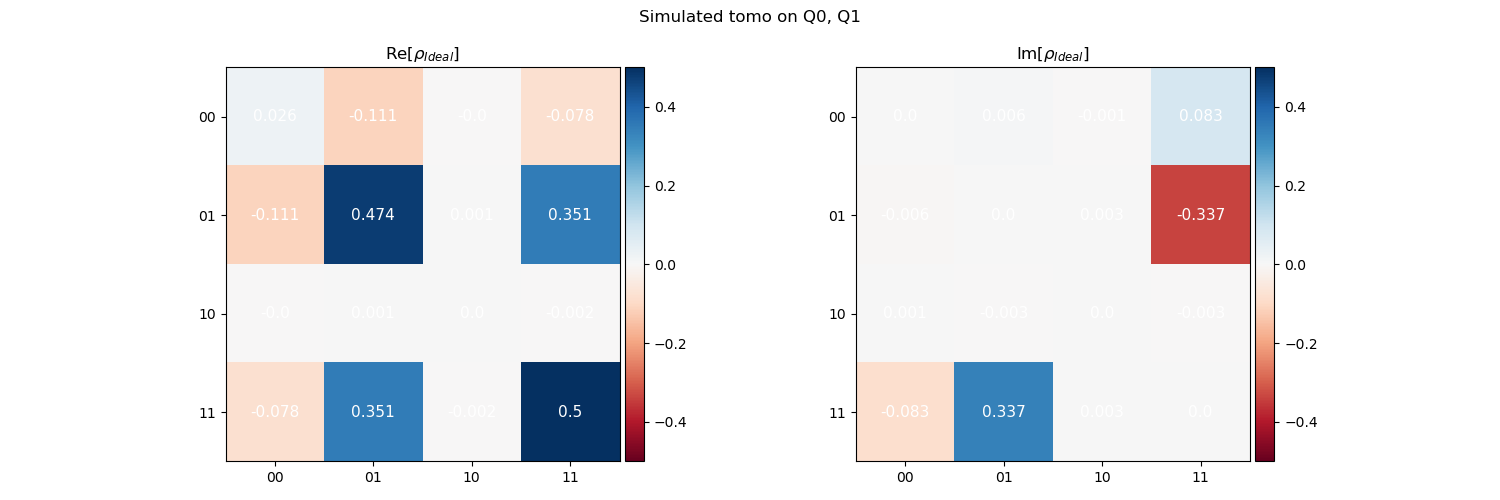

In [390]:
if two_qb:
    show_plot_rho_2d(rho_id=psi_fin*psi_fin.dag(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=0.5)
else:
    show_plot_rho_2d(rho_id=rho_result2q.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=0.5)